Locate files

In [2]:
import pandas as pd
import os

# List of places the file might be hiding
possible_paths = [
    'Data/clustered_fires_nepal.csv',       # If running from root
    '../Data/clustered_fires_nepal.csv',    # If running from notebooks folder
    'clustered_fires_nepal.csv',            # If saved in the same folder
    'data/clustered_fires_nepal.csv',       # Lowercase 'd' check
    '../data/clustered_fires_nepal.csv'     # Lowercase 'd' check (parent)
]

file_found = False
for path in possible_paths:
    if os.path.exists(path):
        print(f"FOUND FILE AT: {path}")
        df = pd.read_csv(path)
        file_found = True
        break

if not file_found:
    print("CRITICAL ERROR: Could not find 'clustered_fires_nepal.csv'.")
    print("Please go back to '03_clustering.ipynb' and run the SAVE cell at the bottom.")
else:
    # Filter for hotspots
    # We check if 'hdbscan_cluster' exists (it should!)
    if 'hdbscan_cluster' in df.columns:
        hotspots = df[df['hdbscan_cluster'] != -1].copy()
        print(f"SUCCESS: Loaded {len(hotspots)} fires from {df['hdbscan_cluster'].nunique()} hotspots.")
    else:
        print("ERROR: File loaded, but it doesn't have 'hdbscan_cluster' column.")
        print("You might have saved the raw data instead of the clustered data.")

FOUND FILE AT: Data/clustered_fires_nepal.csv
SUCCESS: Loaded 7153 fires from 97 hotspots.


The Temporal Analysis (When?)

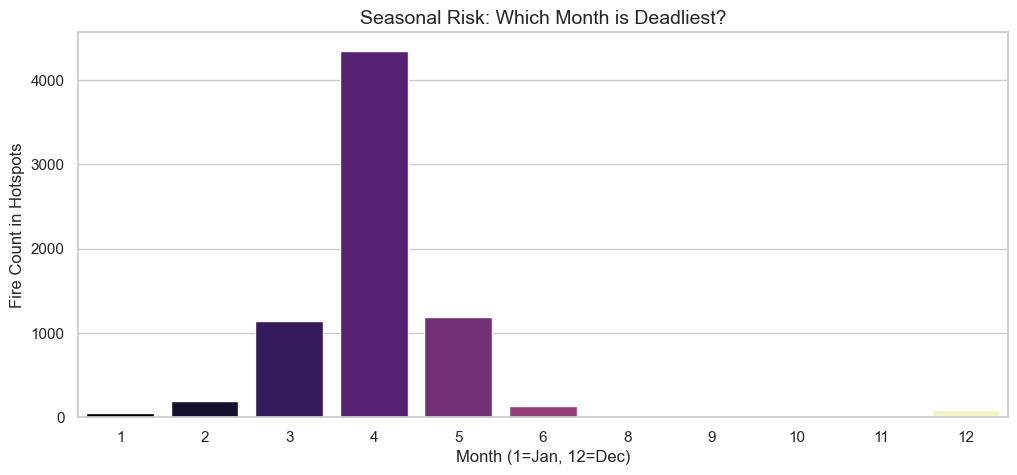

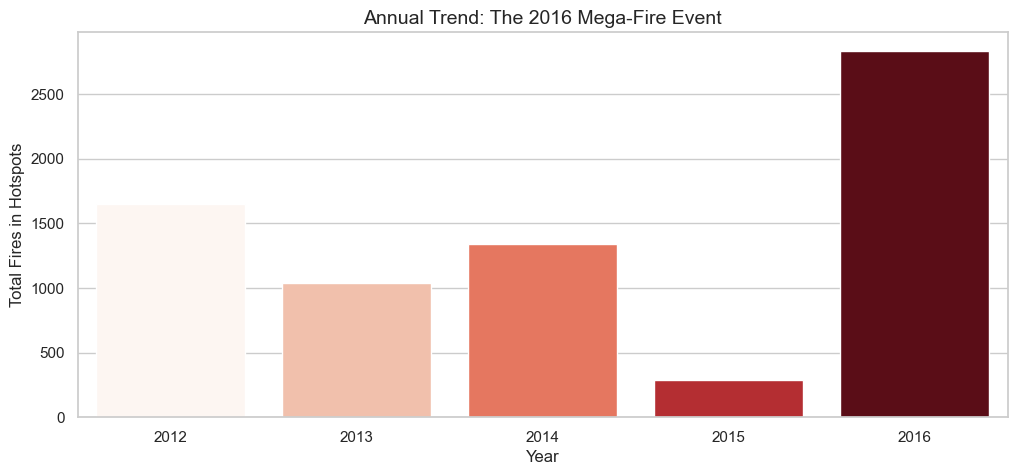

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2. TEMPORAL ANALYSIS (The "When")
# ==========================================
if df is not None:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    # --- PLOT A: SEASONALITY (Month) ---
    plt.figure(figsize=(12, 5))
    # Count fires per month
    # We add hue=... and legend=False to avoid the "FutureWarning"
    sns.countplot(data=hotspots, x='month', hue='month', palette='magma', legend=False)
    
    plt.title("Seasonal Risk: Which Month is Deadliest?", fontsize=14)
    plt.xlabel("Month (1=Jan, 12=Dec)")
    plt.ylabel("Fire Count in Hotspots")
    plt.show()

    # --- PLOT B: YEARLY TREND (Year) ---
    plt.figure(figsize=(12, 5))
    # We add hue=... and legend=False here too
    sns.countplot(data=hotspots, x='year', hue='year', palette='Reds', legend=False)
    
    plt.title("Annual Trend: The 2016 Mega-Fire Event", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Total Fires in Hotspots")
    plt.show()

SPATIAL RISK PROFILE (Where?)


Generatng Risk Profile using district column: 'NAME_3'


C:\Users\pc\AppData\Local\Temp\ipykernel_15664\3842621409.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_counts.values, y=risk_counts.index, palette='inferno')


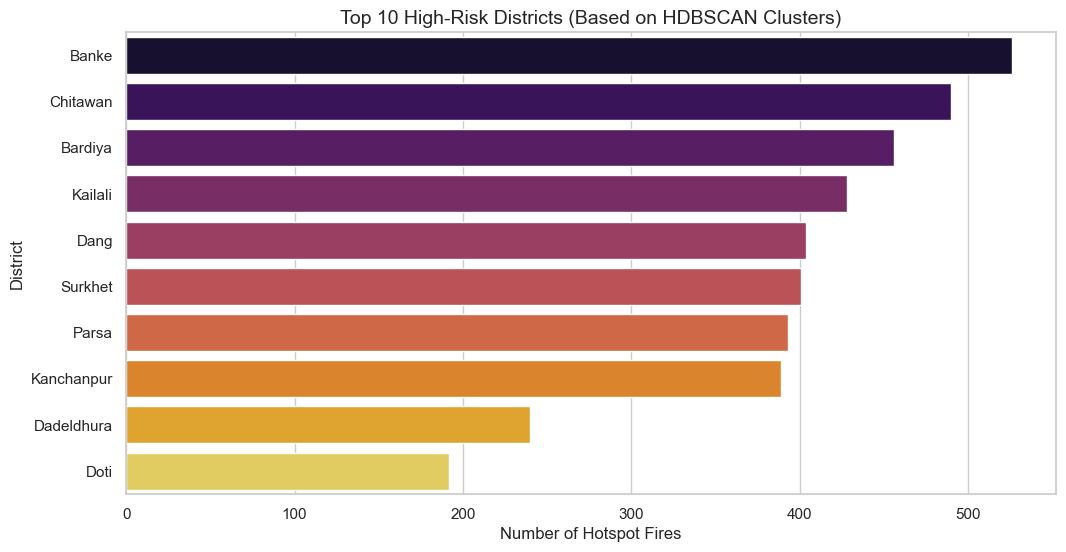

ACTIONABLE INSIGHT:
Disaster management resources should be focused on: ['Banke', 'Chitawan', 'Bardiya']


In [12]:
# 3. SPATIAL RISK PROFILE (The "Where")
# ==========================================
if df is not None:
    # We try to find the District column automatically
    # GADM maps usually name it 'NAME_3', but your join might have named it differently
    possible_dist_cols = ['NAME_3', 'District', 'DISTRICT', 'name_3', 'NAME_2']
    
    dist_col = None
    for col in possible_dist_cols:
        if col in hotspots.columns:
            dist_col = col
            break
            
    if dist_col:
        print(f"\nGeneratng Risk Profile using district column: '{dist_col}'")
        
        # Calculate Top 10 Districts
        risk_counts = hotspots[dist_col].value_counts().head(10)
        
        # --- PLOT C: TOP 10 DISTRICTS ---
        plt.figure(figsize=(12, 6))
        sns.barplot(x=risk_counts.values, y=risk_counts.index, palette='inferno')
        
        plt.title(f"Top 10 High-Risk Districts (Based on HDBSCAN Clusters)", fontsize=14)
        plt.xlabel("Number of Hotspot Fires")
        plt.ylabel('District')
        plt.show()
        
        print("ACTIONABLE INSIGHT:")
        print(f"Disaster management resources should be focused on: {list(risk_counts.index[:3])}")
    else:
        print("\nWARNING: Could not generate Spatial Profile.")
        print("I could not find a column named 'NAME_3' or 'District'.")
        print(f"Available columns are: {hotspots.columns.tolist()}")

Intensity Analysis (Fire Radiative Power)

SUCCESS: Loaded data from Data/clustered_fires_nepal.csv


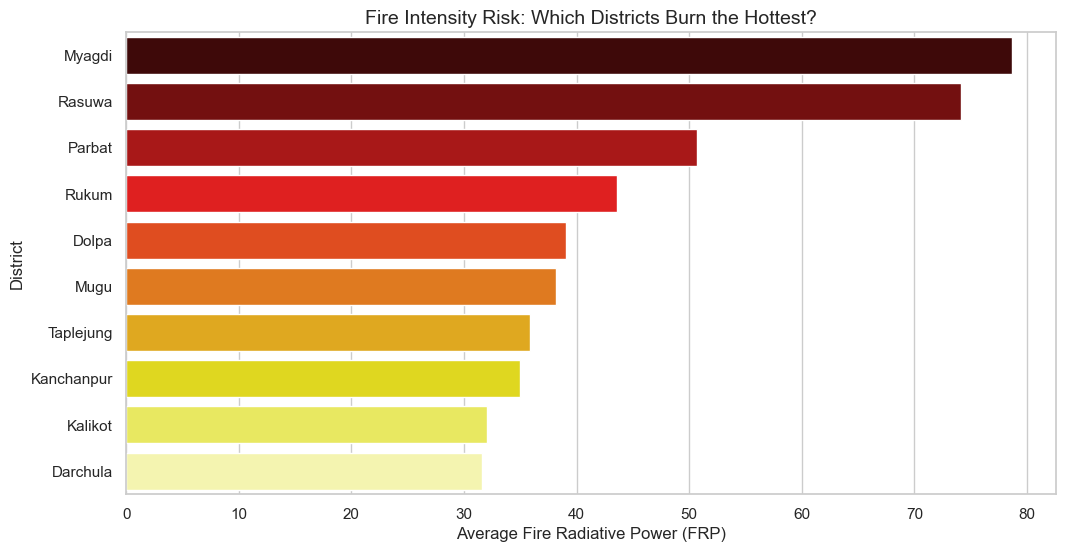

INTERPRETATION:
The districts at the top of this list have high-biomass fires (dense forests).


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. RELOAD DATA (Fix for NameError) ---
possible_paths = ['Data/clustered_fires_nepal.csv', '../Data/clustered_fires_nepal.csv']
df = None

for path in possible_paths:
    if os.path.exists(path):
        df = pd.read_csv(path)
        print(f"SUCCESS: Loaded data from {path}")
        break

if df is not None:
    # --- 2. RE-CREATE THE 'hotspots' VARIABLE ---
    # Filter out noise (-1) so we only analyze the clusters
    if 'hdbscan_cluster' in df.columns:
        hotspots = df[df['hdbscan_cluster'] != -1].copy()
    else:
        print("Error: Data loaded but 'hdbscan_cluster' column is missing.")
        hotspots = pd.DataFrame() # Empty frame to prevent crash below

    # --- 3. RUN INTENSITY ANALYSIS ---
    if not hotspots.empty:
        # A. Find the correct District column name
        possible_dist_cols = ['NAME_3', 'District', 'DISTRICT', 'name_3']
        dist_col = None
        for col in possible_dist_cols:
            if col in hotspots.columns:
                dist_col = col
                break
        
        # B. Find the correct Intensity column (FRP or Brightness)
        intensity_col = 'frp' if 'frp' in hotspots.columns else 'brightness'

        # C. Generate the Plot
        if dist_col and intensity_col in hotspots.columns:
            plt.figure(figsize=(12, 6))
            
            # Calculate Average Intensity per District (Top 10)
            district_intensity = hotspots.groupby(dist_col)[intensity_col].mean().sort_values(ascending=False).head(10)
            
            sns.barplot(x=district_intensity.values, y=district_intensity.index, 
                        hue=district_intensity.index, palette='hot', legend=False)
            
            plt.title(f"Fire Intensity Risk: Which Districts Burn the Hottest?", fontsize=14)
            plt.xlabel(f"Average Fire Radiative Power ({intensity_col.upper()})")
            plt.ylabel("District")
            plt.show()
            
            print("INTERPRETATION:")
            print("The districts at the top of this list have high-biomass fires (dense forests).")
        else:
            print(f"Could not find District or Intensity columns. Available columns: {hotspots.columns.tolist()}")
else:
    print("CRITICAL ERROR: Could not find 'clustered_fires_nepal.csv'. Did you save it in the Clustering notebook?")